### Tree Seed Dispersal modelling using ML

data: [HF120](https://harvardforest1.fas.harvard.edu/exist/apps/datasets/showData.html?id=HF120)

Use regression algorithms to predict distance that each seed travelled from the point at which it was dropped.
 - height = height in meters at which we dropped each seed (meter) 
 - wind.velocity = wind velocity in meters/second taken with a digital anemometer as we dropped each seed (metersPerSecond)  
  
 - distance = distance in meters that each seed travelled from the    point at which we dropped it (meter)
  
  
  
   
  
###### Tree Seed Dispersal modelling using Machine Learning 
Forests are critically important for biodiversity and provide important health and economic benefits. Understanding forests' response to direct mortality resulting from infestation followed by defoliation and indirect mortality in the form of pre-emptive logging is however not very well understood. The efficacy of regeneration of vegetation following hemlock decline depends upon advance regeneration of seedlings and saplings, seed dispersal, and recruitment. In this study, we investigated whether the basic parameters of height of release and wind velocity can be used to model seed dispersal distance in areas both with and without canopies. For modelling, we trained three SVM based machine learning models that allow linear or nonlinear (polynomial and rbf) dependencies. Predicted values of dispersal distance generated by all three models did not provide a good fit to observed dispersal data. Poor fits of the model to the data are likely due to the very small size of the training dataset. Future research should compare model results across open areas  and those with canopies, since it is known that latter diminished the effects of wind and height. More complex models and larger datasets are  necessary to model highly non-linear seed dispersal patterns.


In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import sys, os, pathlib, shutil, platform
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
)
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import OrdinalEncoder

from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

In [3]:
%matplotlib inline

In [4]:
species = ['maple', 'oak', 'birch']
dataFileRootName=['hf120-01-', 'hf120-02-', 'hf120-03-']
dataFileName = [i + j + '.csv' for i, j in zip(dataFileRootName, species)]
# myData = [pd.read_csv(str(pathlib.Path('./../data/hrvardf/HF120') / dataFileName)) for f in dataFileName]

myData = (pd.concat([(pd.read_csv(str(pathlib.Path('./../data/hrvardf/HF120') / f))).assign(spp=spc)
                 for f, spc in zip(dataFileName, species)]
               ,ignore_index=True))

In [5]:
myData.shape
myData.head(2)
myData.tail(2)

(268, 8)

,canopy.type,height,wind.velocity,distance,spp,date,transect,seeds
0,Closed,14.7,0.08,0.11,maple,NaN,NaN,NaN
1,Closed,3.6,0.18,0.26,maple,NaN,NaN,NaN


,canopy.type,height,wind.velocity,distance,spp,date,transect,seeds
266,NaN,NaN,NaN,170.0,birch,2005-11-13,C,0.0
267,NaN,NaN,NaN,180.0,birch,2005-11-13,C,0.0


In [6]:
myData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268 entries, 0 to 267
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   canopy.type    154 non-null    object 
 1   height         154 non-null    float64
 2   wind.velocity  154 non-null    float64
 3   distance       268 non-null    float64
 4   spp            268 non-null    object 
 5   date           114 non-null    object 
 6   transect       114 non-null    object 
 7   seeds          114 non-null    float64
dtypes: float64(4), object(4)
memory usage: 16.9+ KB


In [7]:
myCols = ['height', 'spp', 'distance']
myData[myCols[0]].value_counts(dropna=False) 
myData[myCols[1]].value_counts(dropna=False)
myData[myCols[2]].value_counts(dropna=False)
myData.pivot_table(index = [myCols[0]]
                   , columns = myCols[1]
                   , values =  myCols[2]
                   , aggfunc=np.sum, fill_value=0)



NaN      114
6.70      20
1.00      20
1.50      16
16.85     10
17.15     10
9.20      10
12.30     10
14.70     10
9.15      10
3.60      10
3.40      10
12.25     10
2.00       8
Name: height, dtype: int64

birch    114
oak       81
maple     73
Name: spp, dtype: int64

0.12      7
90.00     6
180.00    6
60.00     6
70.00     6
         ..
0.48      1
1.47      1
0.04      1
2.07      1
3.25      1
Name: distance, Length: 106, dtype: int64

spp,maple,oak
height,,
1.00,1.68,1.15
1.50,1.67,0.94
2.00,0.00,1.79
3.40,3.19,2.88
3.60,4.00,2.73
6.70,11.88,6.21
9.15,7.70,2.45
9.20,9.23,1.86
12.25,17.61,1.62


In [8]:
myCols = ['height', 'spp', 'wind.velocity']
myData[myCols[0]].value_counts(dropna=False) 
myData[myCols[1]].value_counts(dropna=False)
myData[myCols[2]].value_counts(dropna=False)
myData.pivot_table(index = [myCols[0]]
                   , columns = myCols[1]
                   , values =  myCols[2]
                   , aggfunc=np.sum, fill_value=0)

NaN      114
6.70      20
1.00      20
1.50      16
16.85     10
17.15     10
9.20      10
12.30     10
14.70     10
9.15      10
3.60      10
3.40      10
12.25     10
2.00       8
Name: height, dtype: int64

birch    114
oak       81
maple     73
Name: spp, dtype: int64

NaN     114
0.11      6
0.27      5
0.26      4
0.47      3
       ... 
0.35      1
1.15      1
0.96      1
1.19      1
0.12      1
Name: wind.velocity, Length: 102, dtype: int64

spp,maple,oak
height,,
1.00,5.28,4.85
1.50,2.95,6.56
2.00,0.00,4.67
3.40,8.29,8.18
3.60,1.30,4.56
6.70,6.68,7.25
9.15,5.59,4.44
9.20,3.40,5.36
12.25,15.16,11.75


In [9]:
filteredDataML = myData[myData['spp'].isin(['maple','oak'])]
filteredDataML.shape
filteredDataML.head()


(154, 8)

,canopy.type,height,wind.velocity,distance,spp,date,transect,seeds
0,Closed,14.7,0.08,0.11,maple,NaN,NaN,NaN
1,Closed,3.6,0.18,0.26,maple,NaN,NaN,NaN
2,Closed,12.3,1.14,0.35,maple,NaN,NaN,NaN
3,Closed,3.6,0.23,0.45,maple,NaN,NaN,NaN
4,Closed,3.6,0.34,0.60,maple,NaN,NaN,NaN


<Figure size 576x360 with 0 Axes>

Text(0.5, 1.02, 'Graph')

Text(0, 0.5, 'distance')

Text(0.5, 0, 'height')

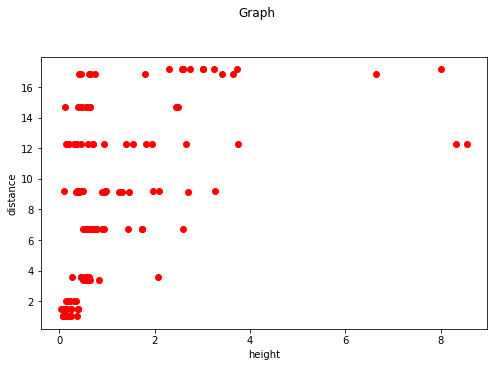

In [10]:
plt.figure(figsize=(8,5))
X_data, y_data = (filteredDataML["distance"].values, filteredDataML["height"].values)
plt.plot(X_data, y_data, 'ro')
plt.suptitle('Graph', y=1.02)
plt.ylabel('distance')
plt.xlabel('height')
plt.show()

In [11]:
X_data, y_data = (filteredDataML[['height','wind.velocity']].values, filteredDataML['distance'].values)


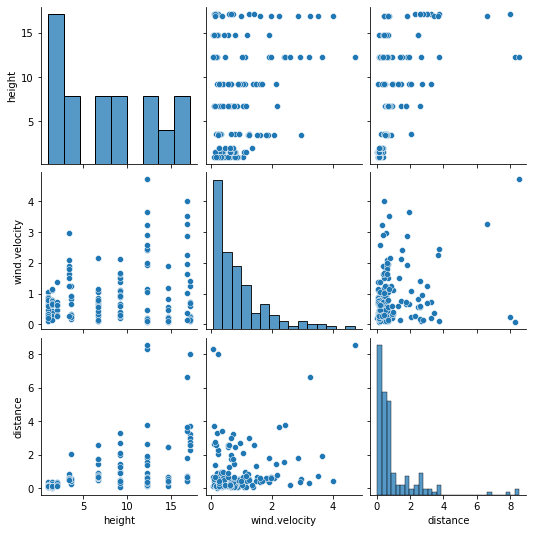

In [12]:
import seaborn as sns
sns.pairplot(filteredDataML[['height','wind.velocity', 'distance', 'spp']])

In [13]:
(filteredDataML[['height','wind.velocity', 'distance', 'spp']]).isnull().sum()

# filteredDataML.dropna(inplace=True)

height           0
wind.velocity    0
distance         0
spp              0
dtype: int64

In [14]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics

X_train, X_test, Y_train, Y_test = train_test_split(X_data, y_data, test_size=0.2, random_state = 1)

In [15]:

model = linear_model.LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

In [16]:
Y_pred_train = model.predict(X_train)


In [17]:
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f'
      % metrics.mean_squared_error(Y_train, Y_pred_train))
print('Coefficient of determination (R^2): %.2f'
      % metrics.r2_score(Y_train, Y_pred_train))

Coefficients: [0.139007   0.22350549]
Intercept: -0.20078464096095772
Mean squared error (MSE): 1.29
Coefficient of determination (R^2): 0.36


In [18]:
Y_pred_test = model.predict(X_test)


In [19]:
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Coefficient of determination (R^2): %.2f'
      % metrics.r2_score(Y_test, Y_pred_test))

print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, Y_pred_test))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, Y_pred_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, Y_pred_test)))

Coefficients: [0.139007   0.22350549]
Intercept: -0.20078464096095772
Coefficient of determination (R^2): -0.08
Mean Absolute Error: 0.956837698524008
Mean Squared Error: 2.446093584630362
Root Mean Squared Error: 1.5639992278228152


<Figure size 360x792 with 0 Axes>

<AxesSubplot:>

Text(0, 0.5, 'Predicted LogS')

<AxesSubplot:>

Text(0, 0.5, 'Predicted LogS')

Text(0.5, 0, 'Experimental LogS')

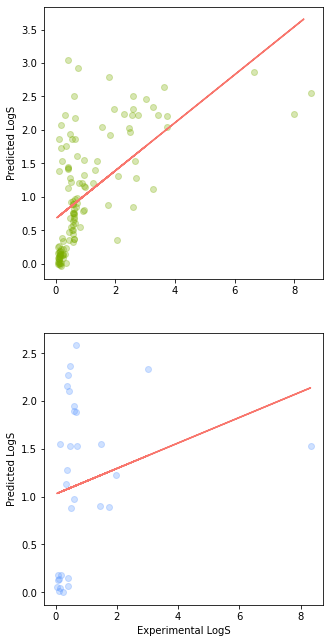

In [20]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(5,11))

# 2 row, 1 column, plot 1
plt.subplot(2, 1, 1)
plt.scatter(x=Y_train, y=Y_pred_train, c="#7CAE00", alpha=0.3)

# Add trendline
# https://stackoverflow.com/questions/26447191/how-to-add-trendline-in-python-matplotlib-dot-scatter-graphs
z = np.polyfit(Y_train, Y_pred_train, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.ylabel('Predicted LogS')


# 2 row, 1 column, plot 2
plt.subplot(2, 1, 2)
plt.scatter(x=Y_test, y=Y_pred_test, c="#619CFF", alpha=0.3)

z = np.polyfit(Y_test, Y_pred_test, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.ylabel('Predicted LogS')
plt.xlabel('Experimental LogS')

plt.savefig('plot_vertical_logS.png')
plt.savefig('plot_vertical_logS.pdf')
plt.show()

In [21]:
# https://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html
from sklearn.svm import SVR

In [22]:
# Fit regression model
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_lin = SVR(kernel='linear', C=100, gamma='auto')
svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1,
               coef0=1)

In [23]:
svrs = [svr_rbf, svr_lin, svr_poly]
kernel_label = ['RBF', 'Linear', 'Polynomial']

model=list()
for ix, svr in enumerate(svrs):
    model.append(svr.fit(X_train, Y_train))

In [24]:
for ix, svr in enumerate(svrs):
#     print(model[ix].support_)
    pass


In [25]:
# plotted_col = 'height'
# X_train[:,0]

Text(0.5, 0.04, 'data')

Text(0.06, 0.5, 'target')

Text(0.5, 0.98, 'Support Vector Regression')

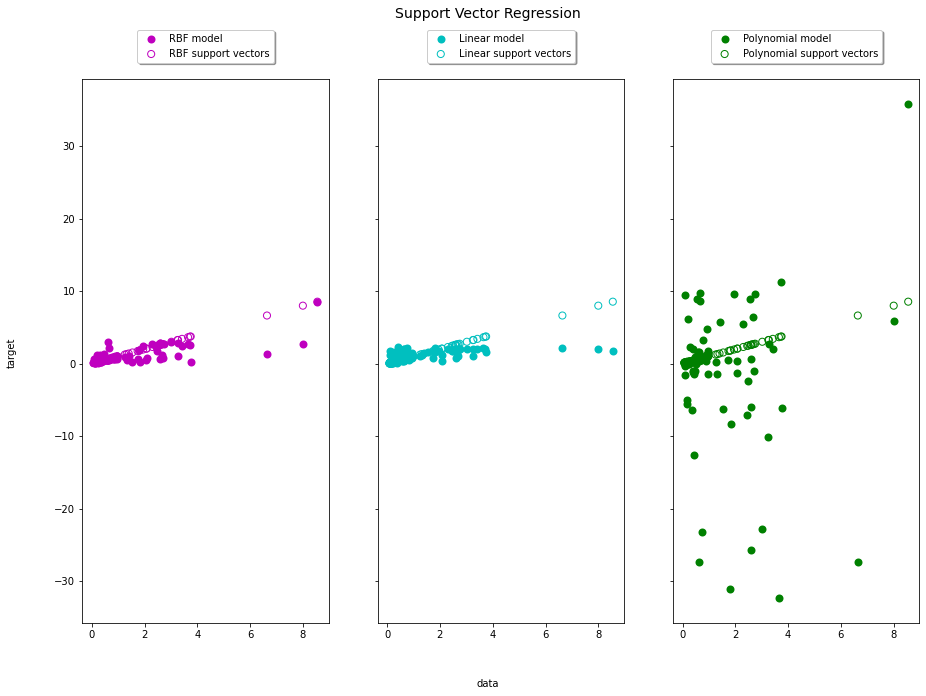

In [26]:
# Look at the results
lw = 2
plotted_col = 'height'
# 'height','wind.velocity'
# model.fit(X_train, Y_train)

# svrs = [svr_rbf, svr_lin, svr_poly]
# kernel_label = ['RBF', 'Linear', 'Polynomial']
model_color = ['m', 'c', 'g']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10), sharey=True)
for ix, svr in enumerate(svrs):
#     horiz_data = X_train[:,0]
    horiz_data = Y_train
    axes[ix].scatter(horiz_data, model[ix].predict(X_train), color=model_color[ix], lw=lw,
                  label='{} model'.format(kernel_label[ix]))
    axes[ix].scatter((horiz_data)[model[ix].support_], Y_train[model[ix].support_], facecolor="none",
                     edgecolor=model_color[ix], s=50,
                     label='{} support vectors'.format(kernel_label[ix]))
#     axes[ix].scatter(X[np.setdiff1d(np.arange(len(X)), svr.support_)],
#                      y[np.setdiff1d(np.arange(len(X)), svr.support_)],
#                      facecolor="none", edgecolor="k", s=50,
#                      label='other training data')
    axes[ix].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
                    ncol=1, fancybox=True, shadow=True)

fig.text(0.5, 0.04, 'data', ha='center', va='center')
fig.text(0.06, 0.5, 'target', ha='center', va='center', rotation='vertical')
fig.suptitle("Support Vector Regression", fontsize=14)
plt.show()

In [27]:
for ix, svr in enumerate(svrs):
    print(str(svr)+':')
    Y_pred_test = model[ix].predict(X_test)
    print('Coefficient of determination (R^2): %.2f'
          % metrics.r2_score(Y_test, Y_pred_test))

    print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, Y_pred_test))
    print('Mean Squared Error:', metrics.mean_squared_error(Y_test, Y_pred_test))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, Y_pred_test)))

SVR(C=100, gamma=0.1):
Coefficient of determination (R^2): -0.34
Mean Absolute Error: 0.9234431613678166
Mean Squared Error: 3.0349686861783107
Root Mean Squared Error: 1.7421161517471533
SVR(C=100, gamma='auto', kernel='linear'):
Coefficient of determination (R^2): 0.03
Mean Absolute Error: 0.8612291702790983
Mean Squared Error: 2.206454241858631
Root Mean Squared Error: 1.4854138284864022
SVR(C=100, coef0=1, gamma='auto', kernel='poly'):
Coefficient of determination (R^2): -30.12
Mean Absolute Error: 4.540076369161197
Mean Squared Error: 70.49133982507718
Root Mean Squared Error: 8.395912090123215
